# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
import lightgbm
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [3]:
%load_ext autoreload

In [4]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
%autoreload
from src.utils import prefilter_items

n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=6000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 6001


In [6]:
%autoreload
from src.metrics import precision_at_k, recall_at_k
#from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [7]:
recommender = MainRecommender(data_train_lvl_1)

100%|██████████| 15.0/15 [00:09<00:00,  2.66it/s, loss=0.0375]
100%|██████████| 6001/6001 [00:00<00:00, 14900.04it/s]


### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [8]:
actual_items_lvl_2=data_train_lvl_2[['user_id', 'item_id']]
actual_items_lvl_2=actual_items_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
actual_items_lvl_2.rename(columns={'item_id': 'actual_items'}, inplace=True)
actual_items_lvl_2.head(2)

,user_id,actual_items
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [9]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']


train_users = data_train_lvl_1['user_id'].unique()
#users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [10]:
users_lvl_2[~users_lvl_2['user_id'].isin(train_users)]

,user_id
724,1813
1903,1984
2052,296


In [11]:
recall_list=[]
recall_at_k_list=[]

#K=[20, 50, 100, 200, 500]
K=[700]

for k in K:
    users_lvl_2_final=users_lvl_2.copy()
    users_lvl_2_final['candidates'] = users_lvl_2_final['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
    act_and_rec_df_lvl_2=actual_items_lvl_2.merge(users_lvl_2_final, on='user_id', how='left')
    act_and_rec_df_lvl_2.head(2)

    for i in range(len(act_and_rec_df_lvl_2['user_id'])):
        recall_list.append(recall_at_k(act_and_rec_df_lvl_2['candidates'][i], act_and_rec_df_lvl_2['actual_items'][i], k=k))
    mean_recall_at_k_1st=np.mean(recall_list)
    print("Качество recall_at_k для k=",k, 'равно:',mean_recall_at_k_1st)
    recall_at_k_list.append(mean_recall_at_k_1st)


Качество recall_at_k для k= 700 равно: 0.19984497434358545


In [12]:
first_level_candidates=users_lvl_2_final

In [13]:
first_level_candidates.head()

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 109..."
2,1753,"[982211, 967041, 915605, 963686, 948640, 13115..."
3,2120,"[5707857, 1029743, 1106523, 5569230, 916122, 8..."
4,1346,"[1135983, 5569309, 1129982, 5574377, 1095712, ..."


In [14]:
s = users_lvl_2_final.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [15]:
users_lvl_2_final = users_lvl_2_final.drop('candidates', axis=1).join(s)
users_lvl_2_final['flag'] = 1

In [16]:
users_lvl_2_final.head(2)

,user_id,item_id,flag
0,2070,1105426,1
0,2070,1097350,1


In [17]:
users_lvl_2_final.shape[0]

1507800

In [18]:
users_lvl_2_final['user_id'].nunique()

2154

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [19]:
data_train_lvl_2.tail(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0
2282324,462,41297773713,635,12731714,1,4.08,304,0.00,2040,91,0.0,0.0


In [20]:
%autoreload
import src.prepare_dataset as prepare_dataset

In [21]:
data_train_lvl_2=prepare_dataset.add_user_items_features(data_train_lvl_2, item_features, user_features)

In [22]:
user_average_bill=prepare_dataset.user_average_bill(data_train_lvl_2) 
overall_average_bill=prepare_dataset.overall_average_bill(user_average_bill) 
user_item_quantity=prepare_dataset.user_item_quantity(data_train_lvl_2) 
overall_average_item_quantity=prepare_dataset.overall_average_item_quantity(user_item_quantity)
user_item_frequency=prepare_dataset.user_item_frequency(data_train_lvl_2) 
overall_item_frequency=prepare_dataset.overall_item_frequency(user_item_frequency) 
user_total_quantity=prepare_dataset.user_total_quantity(data_train_lvl_2) 
avr_total_quantity=prepare_dataset.avr_total_quantity(user_total_quantity) 
user_comodity_popularity=prepare_dataset.user_comodity_popularity(data_train_lvl_2)
overall_comodity_popularity=prepare_dataset.overall_comodity_popularity(user_comodity_popularity)
hh_comp_comodity_popularity=prepare_dataset.hh_comp_comodity_popularity(data_train_lvl_2)

In [23]:
#средний чек
user_average_bill.head()

,user_id,user_average_bill
0,1,3.383393
1,2,3.085542
2,4,4.588189
3,6,2.980156
4,7,2.199049


In [24]:
overall_average_bill

4.869989336002897

In [25]:
#количество покупок товаров пользователем
user_item_quantity.head(2)

,user_id,item_id,user_item_quantity
0,1,820165,1
1,1,829323,1


In [26]:
user_item_quantity[user_item_quantity['item_id']==879194]

,user_id,item_id,user_item_quantity


In [27]:
overall_average_item_quantity.head(2)

,item_id,overall_average_item_quantity
0,28116,1.0
1,28117,1.0


In [28]:
# средняя частота покупок товара пользователем
user_item_frequency.tail()

,user_id,item_id,item_frequency
141936,2500,14111120,0.010417
141937,2500,15511840,0.010417
141938,2500,15595945,0.020833
141939,2500,16223404,0.010417
141940,2500,16809391,0.010417


In [29]:
overall_item_frequency.head(2)

,item_id,overall_item_frequency
0,28116,0.05
1,28117,0.05


In [30]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [31]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [32]:
user_comodity_popularity.tail(2)

,user_id,sub_commodity_desc,user_comodity_popularity
104851,2500,YOGURT MULTI-PACKS,1
104852,2500,YOGURT NOT MULTI-PACKS,20


In [33]:
overall_comodity_popularity.head(2)

,sub_commodity_desc,overall_comodity_popularity
0,,0.0
1,*SCRAPBOOK,1.0


In [34]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [35]:
user_features['hh_comp_desc'].unique()

array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
       'Single Male', '1 Adult Kids'], dtype=object)

In [36]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,...,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,...,EGGS,EGGS - LARGE,1 DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_train_lvl_2.columns

Index(['user_id', 'basket_id', 'day', 'item_id', 'quantity', 'sales_value',
       'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
       'coupon_match_disc', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc'],
      dtype='object')

In [38]:
# data_train_lvl_2_final=data_train_lvl_2.drop(['basket_id', 'day', 'quantity', 'sales_value',
#        'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
#        'coupon_match_disc'])

In [39]:
targets_lvl_2=prepare_dataset.add_part1_features(data_train_lvl_2, users_lvl_2_final, item_features, user_features, user_average_bill, overall_average_bill, overall_average_item_quantity, user_item_quantity,
                      overall_item_frequency,user_item_frequency, user_total_quantity, avr_total_quantity,hh_comp_comodity_popularity)

In [40]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,hh_comp_desc,household_size_desc,kid_category_desc,user_average_bill,user_item_quantity,overall_item_frequency,item_frequency,user_total_quantity,user_log_quantity,hh_comp_comodity_popularity
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,1,None/Unknown,2.18786,3.0,0.009772,0.009772,204,5.31812,0.024390
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,1,None/Unknown,2.18786,1.0,0.038462,0.038462,204,5.31812,0.030255


In [41]:
targets_lvl_2['target'].mean()

0.032356062668418416

In [42]:
# user_comodity_popularity=prepare_dataset.user_comodity_popularity(targets_lvl_2)
# overall_comodity_popularity=prepare_dataset.overall_comodity_popularity(user_comodity_popularity)

In [43]:
targets_lvl_2=prepare_dataset.add_part2_features(targets_lvl_2, overall_comodity_popularity, user_comodity_popularity)

In [44]:
targets_lvl_2=prepare_dataset.targets_fillblanks(targets_lvl_2)

In [45]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,household_size_desc,kid_category_desc,user_average_bill,user_item_quantity,overall_item_frequency,item_frequency,user_total_quantity,user_log_quantity,hh_comp_comodity_popularity,user_comodity_popularity
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,1,None/Unknown,2.18786,3.0,0.009772,0.009772,204,5.31812,0.024390,2.314286
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,1,None/Unknown,2.18786,1.0,0.038462,0.038462,204,5.31812,0.030255,1.884615


In [46]:
targets_lvl_2.groupby(['age_desc'])['user_item_quantity'].sum()

age_desc
19-24    3.891720e+04
25-34    1.255203e+05
35-44    1.698905e+05
45-54    1.408247e+06
55-64    5.157319e+04
65+      5.962820e+04
Name: user_item_quantity, dtype: float64

In [47]:
# temp=pd.pivot_table(targets_lvl_2, index='commodity_desc', columns='hh_comp_desc', 
#                                   values='quantity', # Можно пробоват ьдругие варианты
#                                   aggfunc='sum', 
#                                   fill_value=0
#                                  )

In [48]:
# temp

In [49]:
data_train_lvl_2.to_csv('data_train_lvl_2.csv')

In [50]:
department_quantity=data_train_lvl_2.groupby(['department'])['quantity'].sum().reset_index()

In [51]:
department_quantity

,department,quantity
0,,0
1,AUTOMOTIVE,1
2,CHEF SHOPPE,69
3,CNTRL/STORE SUP,9
4,COSMETICS,524
5,COUP/STR & MFG,51
6,DELI,4131
7,DELI/SNACK BAR,1
8,DRUG GM,23792
9,FLORAL,330


In [52]:
department_quantity[department_quantity['department']=='DELI']

,department,quantity
6,DELI,4131


In [53]:
hh_comp_department=data_train_lvl_2.groupby(['department', 'hh_comp_desc'])['quantity'].sum().reset_index()

In [54]:
hh_comp_department[hh_comp_department['department']=='DELI']

,department,hh_comp_desc,quantity
25,DELI,1 Adult Kids,138
26,DELI,2 Adults Kids,632
27,DELI,2 Adults No Kids,830
28,DELI,Single Female,355
29,DELI,Single Male,266
30,DELI,Unknown,200


In [55]:
hh_comp_department=hh_comp_department.merge(department_quantity, on='department', how='left')
hh_comp_department['hh_comp_department_popularity']=hh_comp_department['quantity_x']/hh_comp_department['quantity_y']
hh_comp_department['hh_comp_department_popularity'].fillna(0, inplace=True)

In [56]:
hh_comp_department.head(10)

,department,hh_comp_desc,quantity_x,quantity_y,hh_comp_department_popularity
0,,1 Adult Kids,0,0,0.000000
1,,2 Adults Kids,0,0,0.000000
2,,2 Adults No Kids,0,0,0.000000
3,,Single Female,0,0,0.000000
4,,Single Male,0,0,0.000000
5,,Unknown,0,0,0.000000
6,CHEF SHOPPE,2 Adults Kids,25,69,0.362319
7,CHEF SHOPPE,2 Adults No Kids,9,69,0.130435
8,CHEF SHOPPE,Single Female,15,69,0.217391
9,CHEF SHOPPE,Single Male,2,69,0.028986


In [57]:
commodity_quantity=data_train_lvl_2.groupby(['commodity_desc'])['quantity'].sum().reset_index()

In [58]:
hh_comp_comodity=data_train_lvl_2.groupby(['commodity_desc', 'hh_comp_desc'])['quantity'].sum().reset_index()


In [59]:
hh_comp_comodity[hh_comp_comodity['commodity_desc']=='BABY FOODS']

,commodity_desc,hh_comp_desc,quantity
52,BABY FOODS,1 Adult Kids,94
53,BABY FOODS,2 Adults Kids,292
54,BABY FOODS,2 Adults No Kids,245
55,BABY FOODS,Single Female,62
56,BABY FOODS,Single Male,191
57,BABY FOODS,Unknown,59


In [60]:
hh_comp_comodity=hh_comp_comodity.merge(commodity_quantity, on='commodity_desc', how='left')
hh_comp_comodity['hh_comp_comodity_popularity']=hh_comp_comodity['quantity_x']/hh_comp_comodity['quantity_y']

In [61]:
hh_comp_comodity[hh_comp_comodity['commodity_desc']=='BABY FOODS']

,commodity_desc,hh_comp_desc,quantity_x,quantity_y,hh_comp_comodity_popularity
52,BABY FOODS,1 Adult Kids,94,1963,0.047886
53,BABY FOODS,2 Adults Kids,292,1963,0.148752
54,BABY FOODS,2 Adults No Kids,245,1963,0.124809
55,BABY FOODS,Single Female,62,1963,0.031584
56,BABY FOODS,Single Male,191,1963,0.097300
57,BABY FOODS,Unknown,59,1963,0.030056


In [62]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [63]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'user_average_bill', 'user_item_quantity', 'overall_item_frequency',
       'item_frequency', 'user_total_quantity', 'user_log_quantity',
       'hh_comp_comodity_popularity', 'user_comodity_popularity'],
      dtype='object')

In [64]:
#cat_feats = X_train.columns[2:].tolist()
#cat_feats = X_train.columns[:-6].tolist()
cat_feats = X_train.columns.tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['user_id',
 'item_id',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_average_bill',
 'user_item_quantity',
 'overall_item_frequency',
 'item_frequency',
 'user_total_quantity',
 'user_log_quantity',
 'hh_comp_comodity_popularity',
 'user_comodity_popularity']

In [65]:
#X_train=X_train.drop(cat_feats, axis=1)

In [66]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'user_average_bill', 'user_item_quantity', 'overall_item_frequency',
       'item_frequency', 'user_total_quantity', 'user_log_quantity',
       'hh_comp_comodity_popularity', 'user_comodity_popularity'],
      dtype='object')

In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
scaler=MinMaxScaler()

In [69]:
#X_train_scalled=scaler.fit_transform(X_train)

In [70]:
#X_train_scalled

In [71]:
#lgb = LGBMClassifier(objective='binary', max_depth=2, categorical_column=cat_feats, n_estimators=500)
lgb = LGBMClassifier(objective='binary', max_depth=2, n_estimators=300, learning_rate=0.01, n_jobs=4)
lgb.fit(X_train, y_train)

#train_preds = lgb.predict(X_train)

C:\Users\mailf\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mailf\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=4, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [72]:
train_pred_proba=lgb.predict_proba(X_train)

In [73]:
# добавим вероятности покупки в датасет

train_pred_proba_df =X_train[['user_id', 'item_id']].copy()
train_pred_proba_df['proba']=train_pred_proba[:,1]

In [74]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'user_average_bill', 'user_item_quantity', 'overall_item_frequency',
       'item_frequency', 'user_total_quantity', 'user_log_quantity',
       'hh_comp_comodity_popularity', 'user_comodity_popularity'],
      dtype='object')

In [75]:
lgb.feature_importances_

array([ 85, 106,   0,   0,   0,  26,  27,   3,   0,   0,   0,   0,   0,
         0,   0,   0, 198, 105, 161,   0,   0,   0, 189])

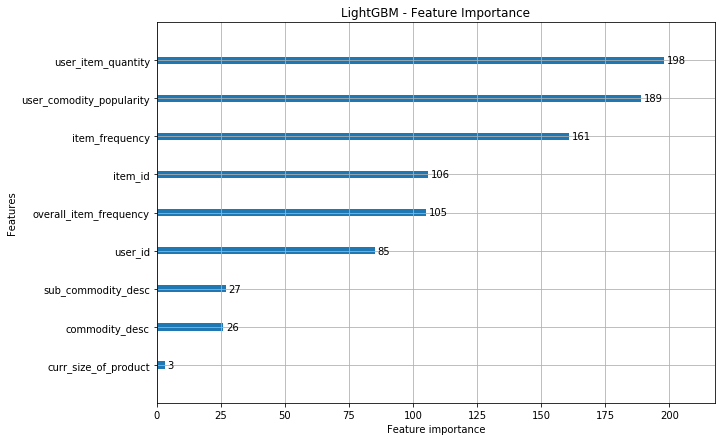

In [76]:
fig, ax = plt.subplots(figsize=(10, 7))
lightgbm.plot_importance(lgb, max_num_features=18, ax=ax)
plt.title("LightGBM - Feature Importance");

In [77]:
train_pred_proba_df.head(2)

,user_id,item_id,proba
0,2070,1105426,0.049773
1,2070,1097350,0.009436


In [78]:
# отсортируем датасет по убыванию вероятности покупки
train_pred_proba_df.sort_values('proba', ascending=False, inplace=True)
train_pred_proba_df.head()

,user_id,item_id,proba
197418,165,1082185,0.885130
114453,451,1082185,0.885130
114452,451,1082185,0.885130
197417,165,1082185,0.885130
328744,40,1082185,0.881646


In [79]:
# получим по кажомуму пользователю отсортированные уникальные рекомендации
train_pred_rec=train_pred_proba_df.groupby('user_id')['item_id'].unique().reset_index()
train_pred_rec.head()

,user_id,item_id
0,1,"[1082185, 9297615, 940947, 1004906, 856942, ....."
1,2,"[1082185, 916122, 899624, 1106523, 979707, ......"
2,4,"[883932, 1004385, 977374, 1133312, 1035676, ....."
3,6,"[1082185, 1098844, 900802, 6548453, 1024306, ...."
4,7,"[1082185, 1106523, 1126899, 902640, 909714, ....."


In [80]:
actual_items=data_train_lvl_2[['user_id', 'item_id']]
actual_items=actual_items.groupby('user_id')['item_id'].unique().reset_index()
actual_items.rename(columns={'item_id': 'actual_items'}, inplace=True)
actual_items.head(2)

,user_id,actual_items
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [81]:
act_and_rec_df_lvl_2=actual_items.merge(train_pred_rec, on='user_id', how='left')
act_and_rec_df_lvl_2.head(2)

,user_id,actual_items,item_id
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1082185, 9297615, 940947, 1004906, 856942, ....."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1082185, 916122, 899624, 1106523, 979707, ......"


In [82]:
l=[]
for i in range(len(act_and_rec_df_lvl_2['user_id'])):
    l.append(precision_at_k(act_and_rec_df_lvl_2['item_id'][i], act_and_rec_df_lvl_2['actual_items'][i], k=5))
mean_precision_at_k=np.mean(l)
print("Качество precision_at_k на трейне", mean_precision_at_k)

Качество precision_at_k на трейне 0.75338904363974


Посмотрим качество на 3м уровне

In [83]:
test_users = pd.DataFrame(data_val_lvl_2['user_id'].unique())
test_users.columns = ['user_id']

In [84]:
test_users.shape

(2042, 1)

In [85]:
train_users = first_level_candidates['user_id'].unique()
test_missing_users=test_users[~test_users['user_id'].isin(train_users)]
test_missing_users.shape

(126, 1)

In [86]:
test_missing_users['candidates'] = test_missing_users['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=700))

C:\Users\mailf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
users_lvl_3_final=test_users.merge(first_level_candidates, on='user_id', how='inner')
users_lvl_3_final.head(2)

,user_id,candidates
0,338,"[876626, 13002975, 938165, 7152319, 823031, 93..."
1,2120,"[5707857, 1029743, 1106523, 5569230, 916122, 8..."


In [88]:
users_lvl_3_final.shape

(1916, 2)

In [89]:
users_lvl_3=pd.concat([users_lvl_3_final,test_missing_users])
test_1st_level_pred=users_lvl_3

In [90]:
users_lvl_3.shape

(2042, 2)

In [91]:
s2 = users_lvl_3.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s2.name = 'item_id'

In [92]:
users_lvl_3 = users_lvl_3.drop('candidates', axis=1).join(s2)
users_lvl_3['flag'] = 1

users_lvl_3.head(5)

,user_id,item_id,flag
0,338,876626,1
0,338,13002975,1
0,338,938165,1
0,338,7152319,1
0,338,823031,1


In [93]:
users_lvl_3_final[users_lvl_3_final['user_id']==3]

,user_id,candidates


In [113]:
data_val_lvl_2.tail()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0
2396803,1167,41656790510,663,6430664,1,8.00,3385,0.00,1059,95,0.0,0.0


In [95]:
targets_lvl_3=prepare_dataset.add_part1_features(data_val_lvl_2, users_lvl_3, item_features, user_features,user_average_bill, overall_average_bill, overall_average_item_quantity, user_item_quantity,
                      overall_item_frequency,user_item_frequency, user_total_quantity, avr_total_quantity, hh_comp_comodity_popularity)

In [96]:
targets_lvl_3=prepare_dataset.add_part2_features(targets_lvl_3, overall_comodity_popularity, user_comodity_popularity)

In [97]:
targets_lvl_3=prepare_dataset.targets_fillblanks(targets_lvl_3)

In [98]:
targets_lvl_3.head(2)




,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,household_size_desc,kid_category_desc,user_average_bill,user_item_quantity,overall_item_frequency,item_frequency,user_total_quantity,user_log_quantity,hh_comp_comodity_popularity,user_comodity_popularity
0,338,876626,0.0,2382,GROCERY,National,DOMESTIC WINE,PREMIUM 750ML WINES,750 ML,45-54,...,2,None/Unknown,3.220225,3.0,0.054545,0.054545,56.0,4.025352,NaN,3.285714
1,338,13002975,1.0,2843,MEAT,National,BEEF,RIBS,,45-54,...,2,None/Unknown,3.220225,1.0,0.015463,0.015463,56.0,4.025352,NaN,1.643478


In [99]:
targets_lvl_3['target'].mean()

0.022494053988265185

In [100]:
X_test = targets_lvl_3.drop('target', axis=1)
y_test = targets_lvl_3[['target']]

In [101]:
X_test.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,household_size_desc,kid_category_desc,user_average_bill,user_item_quantity,overall_item_frequency,item_frequency,user_total_quantity,user_log_quantity,hh_comp_comodity_popularity,user_comodity_popularity
0,338,876626,2382,GROCERY,National,DOMESTIC WINE,PREMIUM 750ML WINES,750 ML,45-54,U,...,2,None/Unknown,3.220225,3.0,0.054545,0.054545,56.0,4.025352,NaN,3.285714
1,338,13002975,2843,MEAT,National,BEEF,RIBS,,45-54,U,...,2,None/Unknown,3.220225,1.0,0.015463,0.015463,56.0,4.025352,NaN,1.643478


In [102]:
#X_test=X_test.drop(cat_feats, axis=1)

In [103]:
X_test.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'user_average_bill', 'user_item_quantity', 'overall_item_frequency',
       'item_frequency', 'user_total_quantity', 'user_log_quantity',
       'hh_comp_comodity_popularity', 'user_comodity_popularity'],
      dtype='object')

In [104]:
X_test[cat_feats] = X_test[cat_feats].astype('category')

cat_feats

['user_id',
 'item_id',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_average_bill',
 'user_item_quantity',
 'overall_item_frequency',
 'item_frequency',
 'user_total_quantity',
 'user_log_quantity',
 'hh_comp_comodity_popularity',
 'user_comodity_popularity']

In [105]:
#X_test_scalled=scaler.fit_transform(X_test)

In [106]:
test_pred_proba=lgb.predict_proba(X_test)

# добавим вероятности покупки в датасет

test_pred_proba_df =X_test[['user_id', 'item_id']].copy()
test_pred_proba_df['proba']=test_pred_proba[:,1]

# отсортируем датасет по убыванию вероятности покупки
test_pred_proba_df.sort_values('proba', ascending=False, inplace=True)
test_pred_proba_df.head()

,user_id,item_id,proba
489745,451,1082185,0.885130
1088640,165,1082185,0.885130
1088032,165,1082185,0.885130
347713,40,1082185,0.881646
347712,40,1082185,0.881646


In [107]:
# получим по кажомуму пользователю отсортированные уникальные рекомендации
test_pred_rec=test_pred_proba_df.groupby('user_id')['item_id'].unique().reset_index()
test_pred_rec.head()

,user_id,item_id
0,1,"[1082185, 9297615, 940947, 1004906, 856942, ....."
1,3,"[1135622, 1016093, 1076697, 949257, 896666, ....."
2,6,"[1082185, 1098844, 900802, 6548453, 1024306, ...."
3,7,"[1082185, 1106523, 1126899, 902640, 909714, ....."
4,8,"[1082185, 1029743, 1044078, 6034857, 872137, ...."


In [108]:
test_actual_items=data_val_lvl_2[['user_id', 'item_id']]
test_actual_items=test_actual_items.groupby('user_id')['item_id'].unique().reset_index()
test_actual_items.rename(columns={'item_id': 'actual_items'}, inplace=True)
test_actual_items.head(2)

,user_id,actual_items
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [109]:
act_and_rec_df_lvl_3=test_actual_items.merge(test_pred_rec, on='user_id', how='left')
act_and_rec_df_lvl_3.head(2)

,user_id,actual_items,item_id
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 9297615, 940947, 1004906, 856942, ....."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1135622, 1016093, 1076697, 949257, 896666, ....."


In [110]:
act_and_rec_df_lvl_3=act_and_rec_df_lvl_3.merge(test_1st_level_pred, on='user_id', how='left')
act_and_rec_df_lvl_3.head(2)

,user_id,actual_items,item_id,candidates
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 9297615, 940947, 1004906, 856942, .....","[9297615, 856942, 5577022, 877391, 9655212, 88..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1135622, 1016093, 1076697, 949257, 896666, .....","[1092937, 1008714, 12132312, 9296795, 1075979,..."


In [111]:
l_1st_level_recall=[]
l_1st_level=[]
l_2nd_level=[]
for i in range(len(act_and_rec_df_lvl_3['user_id'])):
    l_1st_level_recall.append(recall_at_k(act_and_rec_df_lvl_3['candidates'][i], act_and_rec_df_lvl_3['actual_items'][i], k=len(act_and_rec_df_lvl_3['candidates'])))
    l_1st_level.append(precision_at_k(act_and_rec_df_lvl_3['candidates'][i], act_and_rec_df_lvl_3['actual_items'][i], k=5))
    l_2nd_level.append(precision_at_k(act_and_rec_df_lvl_3['item_id'][i], act_and_rec_df_lvl_3['actual_items'][i], k=5))
test_mean_rcall_at_N_1st=np.mean(l_1st_level_recall)
test_mean_precision_at_k_1st=np.mean(l_1st_level)
test_mean_precision_at_k_2nd=np.mean(l_2nd_level)
print("Качество recall_at_N на тесте после простой модели", test_mean_rcall_at_N_1st)
print("Качество precision_at_k на тесте после простой модели", test_mean_precision_at_k_1st)
print("Качество precision_at_k на тесте после LightGBM", test_mean_precision_at_k_2nd)

Качество recall_at_N на тесте после простой модели 0.20401209431404055
Качество precision_at_k на тесте после простой модели 0.13731635651322235
Качество precision_at_k на тесте после LightGBM 0.2574926542605289


### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 